<a href="https://colab.research.google.com/github/yastika/myColabProjects/blob/main/GWP_1__MSc622_Stochastic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE 622 STOCHASTIC MODELING
## Group Work Project 1 Report

Importing essential libraries

In [165]:
import numpy as np
from numpy.fft import fft
from scipy import stats
from scipy.integrate import quad
import pandas as pd
from scipy.optimize import brute, fmin

Initial parameters

In [106]:
S0 = 232.90
r = 0.015
T = 15/250

Heston's Characteristic Function

In [107]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

Computing Put option price using put-call parity

In [ ]:
def H93_put_FFT(S0, K, r, T, C0):
  put_price = C0 + K*np.exp(-r*T) - S0
  return put_price

Reading Google spreadsheet for Calibration

In [108]:
options = pd.read_excel('/content/sample_data/MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx')
options.head()

,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C


#STEP 1 A

In [ ]:
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [ ]:
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

In [ ]:
# Sample DataFrame with 'Type' column indicating 'Call' or 'Put', and 'Price' column containing prices
# Define a function to convert put prices to call prices using call-put parity formula
def put_to_call_parity(row):
    if row['Type'] == 'P':
        return row['Price'] + S0 - row['Strike'] * np.exp(-0.015 * row['Days to maturity']/250)
    else:
        return row['Price']

# Apply the function to create a new column 'Converted Price'
options['Converted_call_Price'] = options.apply(put_to_call_parity, axis=1)
options_15_days = options[options['Days to maturity'] == 15]
# Display the updated DataFrame
options_15_days

,Days to maturity,Strike,Price,Type,Converted_call_Price
0,15,227.5,10.52,C,10.520000
1,15,230.0,10.05,C,10.050000
2,15,232.5,7.75,C,7.750000
3,15,235.0,6.01,C,6.010000
4,15,237.5,4.75,C,4.750000
15,15,227.5,4.32,P,9.924658
16,15,230.0,5.20,P,8.306907
17,15,232.5,6.45,P,7.059156
18,15,235.0,7.56,P,5.671405
19,15,237.5,8.78,P,4.393654


In [ ]:
i = 0
min_MSE = 500

In [ ]:
def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options_15_days.iterrows():
        model_value = H93_call_value(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Converted_call_Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

In [ ]:
calibrated = H93_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  20.086 |  20.086
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  12.679 |   8.761
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |   9.815 |   8.759
 300 | [ 7.10037179  0.05742843  0.11352214 -0.46596154  0.04611934] |   4.121 |   4.121
 400 | [5.50586718e+00 1.19665034e-01 1.04253404e-04 5.11531255e-01
 9.02377801e-02] |   0.345 |   0.345


<ipython-input-9-277e0d7e46d1>:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(
<ipython-input-9-277e0d7e46d1>:29: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(


 500 | [5.53519789e+00 1.19796563e-01 6.23918505e-06 5.16331050e-01
 9.02588916e-02] |   0.345 |   0.345
 600 | [5.53534084e+00 1.19797095e-01 6.17327798e-06 5.16354400e-01
 9.02589874e-02] |   0.345 |   0.345
 700 | [5.53534066e+00 1.19797094e-01 6.17313650e-06 5.16354366e-01
 9.02589871e-02] |   0.345 |   0.345
 800 | [5.53534066e+00 1.19797094e-01 6.17313643e-06 5.16354366e-01
 9.02589871e-02] |   0.345 |   0.345
Optimization terminated successfully.
         Current function value: 0.344516
         Iterations: 272
         Function evaluations: 653


In [ ]:
parameters = ['Kappa','Theta','Sigma','Rho', 'v0']

df_calibrations_1 = pd.DataFrame(calibrated, index = parameters, columns=['Calibrated'])
df_calibrations_1

,Calibrated
Kappa,5.535341
Theta,0.119797
Sigma,0.000006
Rho,0.516354
v0,0.090259


In [ ]:
strikes = options.loc[(options['Days to maturity'] == 15) & (options['Type']=='C'), 'Strike']

call_prices_1 = [0]*len(strikes)
put_prices_1 = [0] * len(strikes)

for i in range(0,len(strikes)):
    call_prices_1[i] = H93_call_value(S0, strikes[i], T, r, calibrated[0], calibrated[1], calibrated[2], calibrated[3], calibrated[4])
    put_prices_1[i] = call_prices_1[i] + strikes[i]*np.exp(-r*T) - S0

print(call_prices_1)
print(put_prices_1)

[10.076699323859145, 8.617630084409655, 7.300274493151903, 6.125023356482501, 5.088746932760301]
[4.472041433724115, 5.510723206470942, 6.691118627409509, 8.013618502936424, 9.475093091410542]


<ipython-input-9-277e0d7e46d1>:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


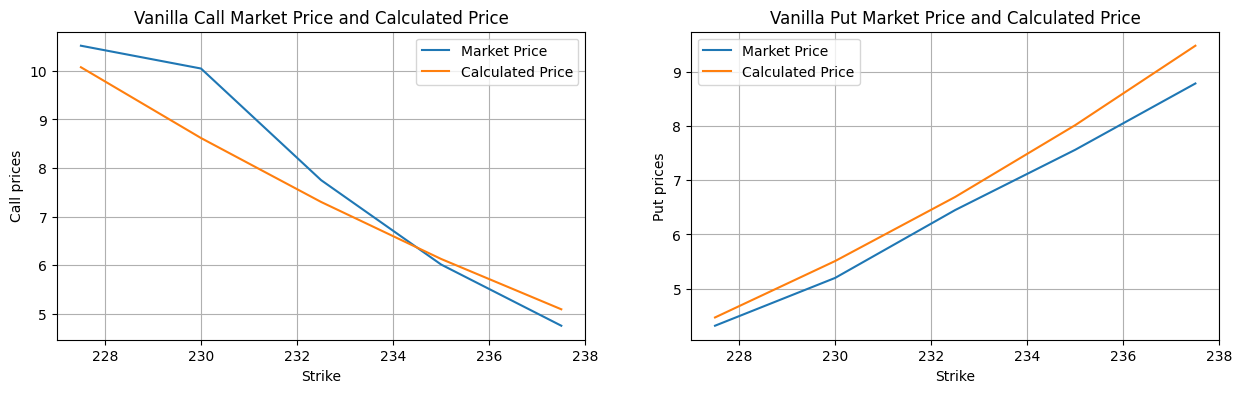

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15,4))

market_call_prices = options.loc[(options['Days to maturity'] == 15) & (options['Type']=='C'), 'Price']
market_put_prices = options.loc[(options['Days to maturity'] == 15) & (options['Type']=='P'), 'Price']

axes[0].plot(strikes, market_call_prices, label='Market Price')
axes[0].plot(strikes, call_prices_1, label='Calculated Price')
axes[0].set_title(f"Vanilla Call Market Price and Calculated Price")
axes[0].set_ylabel("Call prices")
axes[0].set_xlabel("Strike")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(strikes, market_put_prices, label='Market Price')
axes[1].plot(strikes, put_prices_1, label = 'Calculated Price')
axes[1].set_title(f"Vanilla Put Market Price and Calculated Price")
axes[1].set_ylabel("Put prices")
axes[1].set_xlabel("Strike")
axes[1].legend()
axes[1].grid(True)

plt.show()

#STEP 1 B


In [ ]:
def H93_option_price_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, opttype='C'):

    k = np.log(K / S0)
    x0 = np.log(S0 / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    PutValue = CallValue + K*np.exp(-r*T) - S0 # Computing put option price

    return PutValue if opttype == 'P' else CallValue

In [ ]:
i = 0
min_MSE_call = 500
min_MSE_put = 500
call_prices = []

In [ ]:
def H93_error_function_call(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE_call
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se_call = []

    for row, option in options.iterrows():
      if(option["Days to maturity"] == 15 and option["Type"] == 'C'):
        model_call_value = H93_option_price_FFT(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        call_prices.append(model_call_value)
        se_call.append((model_call_value - option["Price"]) ** 2)

    MSE_call = sum(se_call) / len(se_call)

    min_MSE_call = min(min_MSE_call, MSE_call)
    #min_MSE_put = min(min_MSE_put, MSE_put)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE_call, min_MSE_call))
        #print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE_put, min_MSE_put))
    i += 1
    return MSE_call

In [ ]:
def H93_error_function_put(p1):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE_put
    kappa_v, theta_v, sigma_v, rho, v0 = p1
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se_put = []
    for row, option in options.iterrows():
      if(option["Days to maturity"] == 15 and option["Type"] == 'P'):
        model_put_value = H93_option_price_FFT(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            'P'
        )
        se_put.append((model_put_value - option["Price"]) ** 2)

    MSE_put = sum(se_put) / len(se_put)

    min_MSE_put = min(min_MSE_put, MSE_put)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p1), "| %7.3f | %7.3f" % (MSE_put, min_MSE_put))
    i += 1
    return MSE_put

In [ ]:
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    print("Calibration for Vanilla Call")
    p0 = brute(
        H93_error_function_call,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )
    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt_call= fmin(
        H93_error_function_call, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )

    print("Calibration for Vanilla Put")
    p1 = brute(
        H93_error_function_put,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )
    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt_put= fmin(
        H93_error_function_put, p1, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )

    return opt_call, opt_put

In [ ]:
calibrated_call, calibrated_put = H93_calibration_full()

Calibration for Vanilla Call
3125 | [ 2.5   0.01  0.05 -0.25  0.02] |  16.706 |   0.376
3150 | [ 2.5   0.02  0.05 -0.25  0.03] |  11.687 |   0.376
3175 | [2.5  0.02 0.25 0.   0.01] |  23.109 |   0.376
3200 | [2.5  0.03 0.15 0.   0.02] |  15.923 |   0.376
3225 | [2.5  0.04 0.05 0.   0.03] |  11.111 |   0.376
3250 | [ 7.5   0.01  0.05 -0.75  0.01] |  23.562 |   0.376
3275 | [ 7.5   0.01  0.25 -0.75  0.02] |  17.474 |   0.376
3300 | [ 7.5   0.02  0.15 -0.75  0.03] |  12.189 |   0.376
3325 | [ 7.5   0.03  0.05 -0.5   0.01] |  20.330 |   0.376
3350 | [ 7.5   0.03  0.25 -0.5   0.02] |  15.216 |   0.376
3375 | [ 7.5   0.04  0.15 -0.5   0.03] |  10.614 |   0.376
3400 | [ 7.65    0.0408  0.1425 -0.765   0.0306] |  10.341 |   0.376
3425 | [6.57275956 0.0874393  0.06944652 0.22727011 0.07592071] |   1.393 |   0.376
3450 | [4.57580531 0.12337625 0.02591666 0.78339304 0.10440594] |   0.385 |   0.376
3475 | [4.64887959 0.1209919  0.0277908  0.73502536 0.10261728] |   0.382 |   0.376
3500 | [4.499292

In [ ]:
parameters = ['Kappa','Theta','Sigma','Rho', 'v0']
calibrations = zip(calibrated_call, calibrated_put)

df_calibrations = pd.DataFrame(calibrations, index = parameters, columns=['Call','Put'])

,Call,Put
Kappa,3.048035e+00,8.347654
Theta,1.247787e-01,0.085308
Sigma,1.953725e-07,0.000003
Rho,6.155366e-01,0.234148
v0,1.033613e-01,0.084457


In [ ]:
call_params = df_calibrations.loc[:, 'Call']
put_params = df_calibrations.loc[:, 'Put']

In [ ]:
#Calculating call prices using the caliberated parameters
call_strikes = options.loc[(options['Days to maturity'] == 15) & (options['Type']=='C'), 'Strike']
put_strikes = options.loc[(options['Days to maturity'] == 15) & (options['Type']=='P'), 'Strike']

call_prices = [0]*len(call_strikes)
put_prices = [0] * len(put_strikes)



for i in range(0,len(call_strikes)):
    call_prices[i] = H93_option_price_FFT(S0, call_strikes[i], T, r, call_params[0], call_params[1], call_params[2], call_prices[3], call_params[4])
    put_prices[i] = H93_option_price_FFT(S0, call_strikes[i], T, r, call_params[0], call_params[1], call_params[2], call_prices[3], call_params[4],"P")


#print(call_prices)
#print(put_prices)

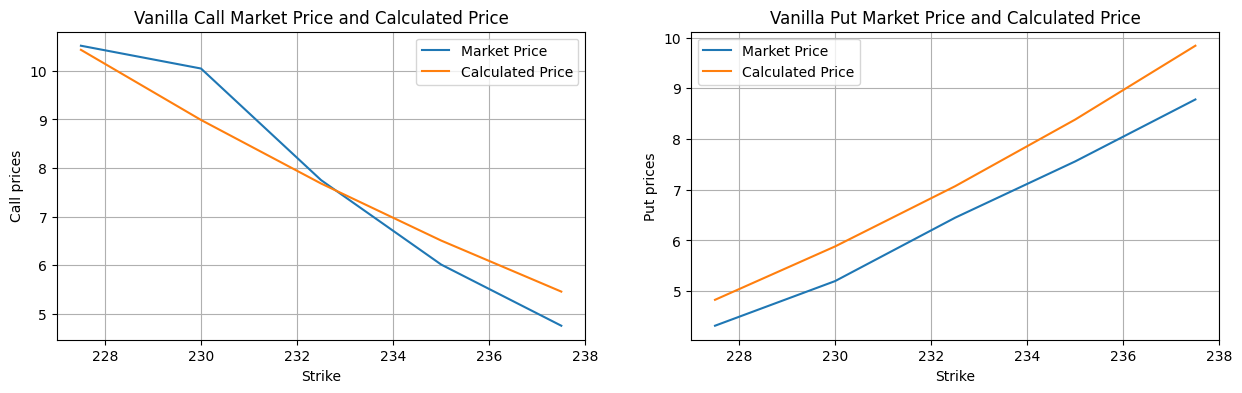

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15,4))

market_call_prices = options.loc[(options['Days to maturity'] == 15) & (options['Type']=='C'), 'Price']
market_put_prices = options.loc[(options['Days to maturity'] == 15) & (options['Type']=='P'), 'Price']

axes[0].plot(call_strikes, market_call_prices, label='Market Price')
axes[0].plot(call_strikes, call_prices, label='Calculated Price')
axes[0].set_title(f"Vanilla Call Market Price and Calculated Price")
axes[0].set_ylabel("Call prices")
axes[0].set_xlabel("Strike")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(put_strikes, market_put_prices, label='Market Price')
axes[1].plot(put_strikes, put_prices, label = 'Calculated Price')
axes[1].set_title(f"Vanilla Put Market Price and Calculated Price")
axes[1].set_ylabel("Put prices")
axes[1].set_xlabel("Strike")
axes[1].legend()
axes[1].grid(True)

plt.show()

#STEP 1 C

In [ ]:
import numpy as np

def asian_call_option_price(spot_price, strike_price, volatility, interest_rate, maturity_days, num_simulations):
    dt = 1 / 252  # Assuming daily time steps for simplicity
    sqrt_dt = np.sqrt(dt)

    simulations = np.zeros((num_simulations, maturity_days + 1))
    simulations[:, 0] = spot_price

    for t in range(1, maturity_days + 1):
        # Generate random normal increments
        z = np.random.normal(size=num_simulations)

        # Geometric Brownian Motion
        simulations[:, t] = simulations[:, t - 1] * np.exp((interest_rate - 0.5 * volatility**2) * dt +
                                                            volatility * sqrt_dt * z)

    # Calculate average prices over the maturity period
    average_prices = np.mean(simulations[:, 1:], axis=1)

    # Asian call option payoff
    option_payoff = np.maximum(average_prices - strike_price, 0)

    # Discounted present value
    discount_factor = np.exp(-interest_rate * maturity_days / 252)
    fair_price = discount_factor * np.mean(option_payoff)

    return fair_price

# Calibrated parameters (parameters from Step 1B computed by team member B)
spot_price = 232.9
strike_price = 232.9
volatility = 0.000006
interest_rate = 0.015
maturity_days = 20
num_simulations = 100000

# Obtain fair price using Monte Carlo simulation
fair_price = asian_call_option_price(spot_price, strike_price, volatility, interest_rate, maturity_days, num_simulations)

# Apply the 4% fee as part of the bank's profit
final_price = 1.04 * fair_price

print(f"Fair Price: {fair_price:.15f}")
print(f"Final Price (including 4% fee): {final_price:.15f}")


Fair Price: 0.145448445418806
Final Price (including 4% fee): 0.151266383235558


# STEP 2

Now Client has decided time to maturity as 60 days

In [109]:
T_60 = 60/250
kappa_v, theta_v, sigma_v, rho, v0 = np.array([5.535341, 0.119797, 0.000006, 0.516354, 0.090259])
#kappa_v, theta_v, sigma_v, rho, v0 = np.array([4.59755560e+00, 1.23739981e-01, 4.37641120e-06, 5.85913822e-01, 9.50633855e-02])

In [110]:
def put_to_call_parity(row):
    if row['Type'] == 'P':
        return row['Price'] + S0 - row['Strike'] * np.exp(-0.015 * row['Days to maturity']/250)
    else:
        return row['Price']

# Apply the function to create a new column 'Converted Price'
options['Converted_call_Price'] = options.apply(put_to_call_parity, axis=1)
options_60_days = options[options['Days to maturity'] == 60]
# Display the updated DataFrame
options_60_days

,Days to maturity,Strike,Price,Type,Converted_call_Price
5,60,227.5,16.78,C,16.780000
6,60,230.0,17.65,C,17.650000
7,60,232.5,16.86,C,16.860000
8,60,235.0,16.05,C,16.050000
9,60,237.5,15.10,C,15.100000
20,60,227.5,11.03,P,17.247528
21,60,230.0,12.15,P,15.876511
22,60,232.5,13.37,P,14.605495
23,60,235.0,14.75,P,13.494479
24,60,237.5,15.62,P,11.873463


Since we have already defined a function for Heston's characteristic here we are going to define only Merton and Bates Characteristic function

In [111]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [112]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

#Step 2A

In [113]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [114]:
def B96_call_value_lewis(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

In [115]:
#defining the error function
i = 0
min_MSE = 5000.0
local_opt = False
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options_60_days.iterrows():
        model_value = B96_call_value_lewis(
            S0,
            option["Strike"],
            T_60,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Converted_call_Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [116]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [117]:
params = B96_calibration_short()

<ipython-input-114-a49a00ab937b>:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


   0 | [ 0.  -0.5  0. ] |   1.617 |   1.617
 100 | [ 0.17161137 -0.14982767  0.00146277] |   1.546 |   1.546
 200 | [ 0.8124231  -0.06669267  0.02500995] |   1.542 |   1.542
 300 | [ 1.68478768 -0.04703239  0.01353536] |   1.541 |   1.541
 400 | [ 5.83245491e+00 -2.56788521e-02  2.42862689e-03] |   1.540 |   1.540
 500 | [ 9.68320635e+00 -2.03610755e-02  1.47774080e-04] |   1.539 |   1.539
 600 | [ 2.43583442e+01 -1.25308109e-02  2.75206713e-03] |   1.539 |   1.539
 700 | [ 4.36572295e+01 -9.30746996e-03  2.42011064e-03] |   1.539 |   1.539


<ipython-input-116-9b5b5c0b4934>:20: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt2 = fmin(


In [118]:
params

array([ 4.52460899e+01, -9.42783914e-03,  1.51455990e-04])

In [119]:
def B96_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    values = []
    for row, option in options_60_days.iterrows():
        model_value = B96_call_value_lewis(
            S0,
            option["Strike"],
            T_60,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)

In [120]:
lamb, mu, delta = params

In [121]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [122]:
i = 0
min_MSE = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options_60_days.iterrows():
        model_value = B96_call_value_lewis(
            S0,
            option["Strike"],
            T_60,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Converted_call_Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [123]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

In [124]:
params_full = B96_calibration_full()

<ipython-input-114-a49a00ab937b>:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


   0 | [ 5.53534100e+00  1.19797000e-01  6.00000000e-06  5.16354000e-01
  9.02590000e-02  4.52460899e+01 -9.42783914e-03  1.51455990e-04] |   1.539 |   1.539
  25 | [ 5.56121116e+00  1.20420732e-01  6.05968243e-06  5.21490210e-01
  9.00104672e-02  4.56961560e+01 -9.36314521e-03  1.52962533e-04] |   1.539 |   1.539
  50 | [ 5.60446261e+00  1.19987207e-01  6.04475582e-06  4.82033768e-01
  9.01608414e-02  4.52799731e+01 -9.34019532e-03  1.59374642e-04] |   1.539 |   1.539
  75 | [ 5.59148094e+00  1.19858264e-01  6.03060523e-06  5.07536811e-01
  9.01855655e-02  4.53723275e+01 -9.34569782e-03  1.56993051e-04] |   1.539 |   1.539
 100 | [ 5.57913175e+00  1.19892940e-01  6.02884734e-06  5.04841445e-01
  9.02374368e-02  4.51981590e+01 -9.34943147e-03  1.56920492e-04] |   1.539 |   1.539
 125 | [ 5.57767588e+00  1.19888967e-01  6.02250468e-06  5.07304298e-01
  9.02275646e-02  4.52130090e+01 -9.35336779e-03  1.56399510e-04] |   1.539 |   1.539
 150 | [ 5.57811029e+00  1.19892539e-01  6.02848000e

In [131]:
df_index = ['Kappa', 'Theta','Sigma', 'Rho','v0','Lambda','Mu','Delta']
df_params_lewis = pd.DataFrame(params_full, index = df_index, columns=['Fully Calibrated'])
df_params_lewis

,Fully Calibrated
Kappa,5.577709
Theta,0.119891
Sigma,0.000006
Rho,0.507124
v0,0.090227
Lambda,45.218065
Mu,-0.009355
Delta,0.000156


In [148]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options_60_days.iterrows():
        model_value = B96_call_value_lewis(
            S0,
            option["Strike"],
            T_60,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        values.append(model_value)

    return np.array(values)

In [ ]:
grouped = options_60_days.groupby(options.Type)
call_options = grouped.get_group("C")
put_options = grouped.get_group("P")

call_options

,Days to maturity,Strike,Price,Type,Converted_call_Price,Model
5,60,227.5,16.78,C,16.78,18.025010
6,60,230.0,17.65,C,17.65,16.725525
7,60,232.5,16.86,C,16.86,15.493171
8,60,235.0,16.05,C,16.05,14.327251
9,60,237.5,15.10,C,15.10,13.226712


In [146]:
def plot_full_calibration_results(p0):
    #call_options["Model"] = B96_calculate_model_values(p0)
    #put_options["Model"] = B96_calculate_model_values(p0)

     # Ensure that the model values have the same length as the index
    call_options["Model"] = B96_calculate_model_values(p0)[:len(call_options)]
    put_options["Model"] = B96_calculate_model_values(p0)[len(call_options):]

    fig, axes = plt.subplots(2, 2, figsize=(15,4))


    #plt.figure(figsize=(8, 6))
    #plt.subplot(121)
    axes[0][0].grid()
    axes[0][0].set_title("Call Options: 60 Days to Maturity")
    axes[0][0].set_ylabel("option values")
    axes[0][0].set_xlabel("Strike")
    axes[0][0].plot(call_options.Strike, call_options.Price, "b", label="market")
    axes[0][0].plot(call_options.Strike, call_options.Model, "ro", label="model")
    axes[0][0].legend(loc=0)
    axes[0][0].axis(
        [
            min(call_options.Strike) - 10,
            max(call_options.Strike) + 10,
            min(call_options.Price) - 10,
            max(call_options.Price) + 10,
        ]
    )
    #plt.subplot(122)
    axes[0][1].grid()
    wi = 5.0
    diffs = call_options.Model.values - call_options.Price.values
    axes[0][1].set_title("Call Option: Difference")
    axes[0][1].bar(call_options.Strike.values - wi / 2, diffs, width=wi)
    axes[0][1].set_ylabel("difference")
    axes[0][1].set_xlabel("Strike")
    axes[0][1].axis(
        [
            min(call_options.Strike) - 10,
            max(call_options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )


    #plt.subplot(221)
    axes[1][0].grid()
    axes[1][0].set_title("Put Option: 60 Days to Maturity")
    axes[1][0].set_ylabel("option values")
    axes[1][0].set_xlabel("Strike")
    axes[1][0].plot(put_options.Strike, put_options.Price, "b", label="market")
    axes[1][0].plot(put_options.Strike, put_options.Model, "ro", label="model")
    axes[1][0].legend(loc=0)
    axes[1][0].axis(
        [
            min(put_options.Strike) - 10,
            max(put_options.Strike) + 10,
            min(put_options.Price) - 10,
            max(put_options.Price) + 10,
        ]
    )
    #plt.subplot(222)
    axes[1][1].grid()
    wi = 5.0
    diffs = put_options.Model.values - put_options.Price.values
    axes[1][1].set_title("Put Option: Difference")
    axes[1][1].bar(put_options.Strike.values - wi / 2, diffs, width=wi)
    axes[1][1].set_ylabel("difference")
    axes[1][1].set_xlabel("Strike")
    axes[1][1].axis(
        [
            min(put_options.Strike) - 10,
            max(put_options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )

    fig.tight_layout()



<ipython-input-114-a49a00ab937b>:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(
<ipython-input-146-19076d4be4ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_options["Model"] = B96_calculate_model_values(p0)[:len(call_options)]
<ipython-input-146-19076d4be4ef>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  put_options["Model"] = B96_calculate_model_values(

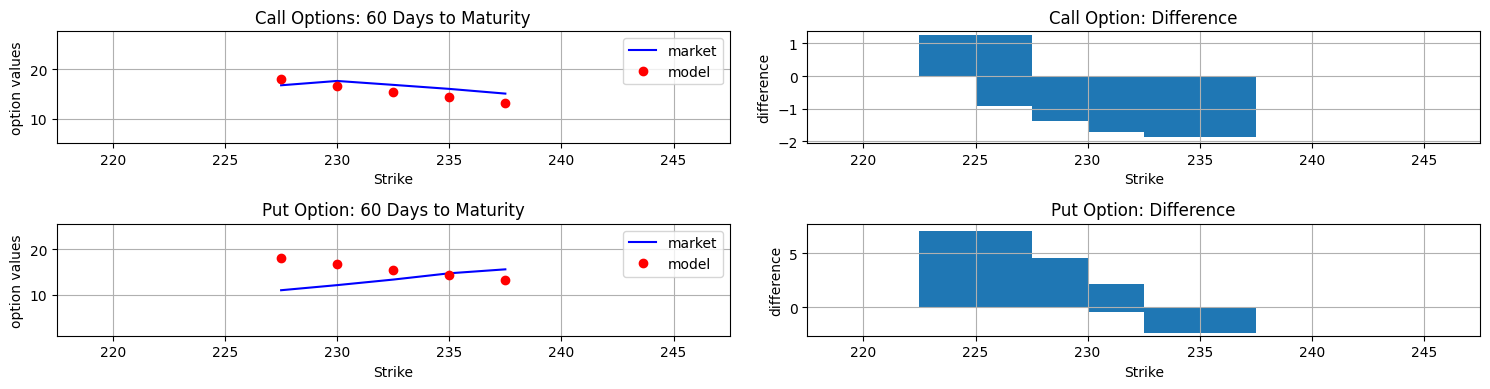

In [149]:
plot_full_calibration_results(params_full)

#Step 2B

In [132]:
def B96_call_value_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

In [133]:
#defining the error function
i = 0
min_MSE = 5000.0
local_opt = False
def B96_error_function_FFT(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options_60_days.iterrows():
        model_value = B96_call_value_FFT(
            S0,
            option["Strike"],
            T_60,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Converted_call_Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    #if local_opt:
        #penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        #return MSE + penalty
    return MSE

In [134]:
def B96_calibration_short_FFT():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function_FFT,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function_FFT,
        opt1,
        xtol=0.01,
        ftol=0.001,
        maxiter=500,
        maxfun=750,
    )
    return opt2

In [135]:
params_2 = B96_calibration_short_FFT()

   0 | [ 0.  -0.5  0. ] |   1.616 |   1.616
Optimization terminated successfully.
         Current function value: 1.547134
         Iterations: 6
         Function evaluations: 14


In [136]:
print(params_2)
lamb, mu, delta = params_2

[ 0.105 -0.21   0.   ]


In [137]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [138]:
i = 0
min_MSE = 5000.0


def B96_full_error_function_FFT(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options_60_days.iterrows():
        model_value = B96_call_value_FFT(
            S0,
            option["Strike"],
            T_60,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Converted_call_Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [139]:
def B96_calibration_full_FFT():
    opt = fmin(
        B96_full_error_function_FFT, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

In [140]:
params_full_FFT = B96_calibration_full_FFT()

   0 | [ 5.535341e+00  1.197970e-01  6.000000e-06  5.163540e-01  9.025900e-02
  1.050000e-01 -2.100000e-01  0.000000e+00] |   1.547 |   1.547
  25 | [ 5.57290249e+00  1.19916593e-01  6.04071455e-06  5.19857854e-01
  9.03190416e-02  1.04974223e-01 -2.08483420e-01  1.43303792e-04] |   1.547 |   1.545
  50 | [ 6.93885947e+00  1.22039925e-01  6.91696914e-06  5.71781114e-01
  9.13984505e-02  1.06154976e-01 -6.37435550e-02  9.58398923e-04] |   1.539 |   1.539
  75 | [ 6.58844267e+00  1.22271556e-01  7.05186229e-06  5.83916266e-01
  9.16657825e-02  1.04621164e-01 -6.33263603e-02  1.08173144e-03] |   1.539 |   1.538
 100 | [ 6.71528042e+00  1.22971069e-01  7.53432122e-06  5.98072209e-01
  9.18361684e-02  1.08618120e-01 -1.38402307e-02  1.31012074e-03] |   1.538 |   1.538
 125 | [ 6.79988538e+00  1.22717131e-01  7.50193939e-06  6.05530539e-01
  9.18899422e-02  1.09045575e-01 -5.22470304e-03  1.34132620e-03] |   1.538 |   1.538
 150 | [ 6.87541437e+00  1.22504421e-01  7.40757065e-06  6.08453452e

In [ ]:
params_full_FFT

array([ 6.85558631e+00,  1.22470490e-01,  7.40530474e-06,  6.08048523e-01,
        9.18937620e-02,  1.09039846e-01, -5.55168045e-03,  1.33406709e-03])

In [141]:
df_params_FFT = pd.DataFrame(params_full_FFT, index = df_index, columns=['Fully Calibrated'])
df_params_FFT

,Fully Calibrated
Kappa,6.855586
Theta,0.122470
Sigma,0.000007
Rho,0.608049
v0,0.091894
Lambda,0.109040
Mu,-0.005552
Delta,0.001334


In [142]:
grouped = options_60_days.groupby(options.Type)
call_options = grouped.get_group("C")
put_options = grouped.get_group("P")

In [143]:
def B96_calculate_model_values_FFT(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options_60_days.iterrows():
        model_value = B96_call_value_FFT(
            S0,
            option["Strike"],
            T_60,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        values.append(model_value)

    return np.array(values)

In [152]:
import matplotlib.pyplot as plt
def plot_full_calibration_results_FFT(p0):
    call_options["Model"] = B96_calculate_model_values_FFT(p0)[:len(call_options)]
    put_options["Model"] = B96_calculate_model_values_FFT(p0)[len(call_options):]

    fig, axes = plt.subplots(2, 2, figsize=(15,4))


    #plt.figure(figsize=(8, 6))
    #plt.subplot(121)
    axes[0][0].grid()
    axes[0][0].set_title("Call Options: 60 Days to Maturity")
    axes[0][0].set_ylabel("option values")
    axes[0][0].set_xlabel("Strike")
    axes[0][0].plot(call_options.Strike, call_options.Price, "b", label="market")
    axes[0][0].plot(call_options.Strike, call_options.Model, "ro", label="model")
    axes[0][0].legend(loc=0)
    axes[0][0].axis(
        [
            min(call_options.Strike) - 10,
            max(call_options.Strike) + 10,
            min(call_options.Price) - 10,
            max(call_options.Price) + 10,
        ]
    )
    #plt.subplot(122)
    axes[0][1].grid()
    wi = 5.0
    diffs = call_options.Model.values - call_options.Price.values
    axes[0][1].bar(call_options.Strike.values - wi / 2, diffs, width=wi)
    axes[0][1].set_title("Call Options: Difference")
    axes[0][1].set_ylabel("difference")
    axes[0][1].set_xlabel("Strike")
    axes[0][1].axis(
        [
            min(call_options.Strike) - 10,
            max(call_options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )


    #plt.subplot(221)
    axes[1][0].grid()
    axes[1][0].set_title("Put Option: 60 Days to Maturity")
    axes[1][0].set_ylabel("option values")
    axes[1][0].set_xlabel("Strike")
    axes[1][0].plot(put_options.Strike, put_options.Price, "b", label="market")
    axes[1][0].plot(put_options.Strike, put_options.Model, "ro", label="model")
    axes[1][0].legend(loc=0)
    axes[1][0].axis(
        [
            min(put_options.Strike) - 10,
            max(put_options.Strike) + 10,
            min(put_options.Price) - 10,
            max(put_options.Price) + 10,
        ]
    )
    #plt.subplot(222)
    axes[1][1].grid()
    wi = 5.0
    diffs = put_options.Model.values - put_options.Price.values
    axes[1][1].bar(put_options.Strike.values - wi / 2, diffs, width=wi)
    axes[1][1].set_title("Put Options: Difference")
    axes[1][1].set_ylabel("difference")
    axes[1][1].set_xlabel("Strike")
    axes[1][1].axis(
        [
            min(put_options.Strike) - 10,
            max(put_options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )

    fig.tight_layout()

<ipython-input-152-8ed010ab4959>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_options["Model"] = B96_calculate_model_values_FFT(p0)[:len(call_options)]
<ipython-input-152-8ed010ab4959>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  put_options["Model"] = B96_calculate_model_values_FFT(p0)[len(call_options):]


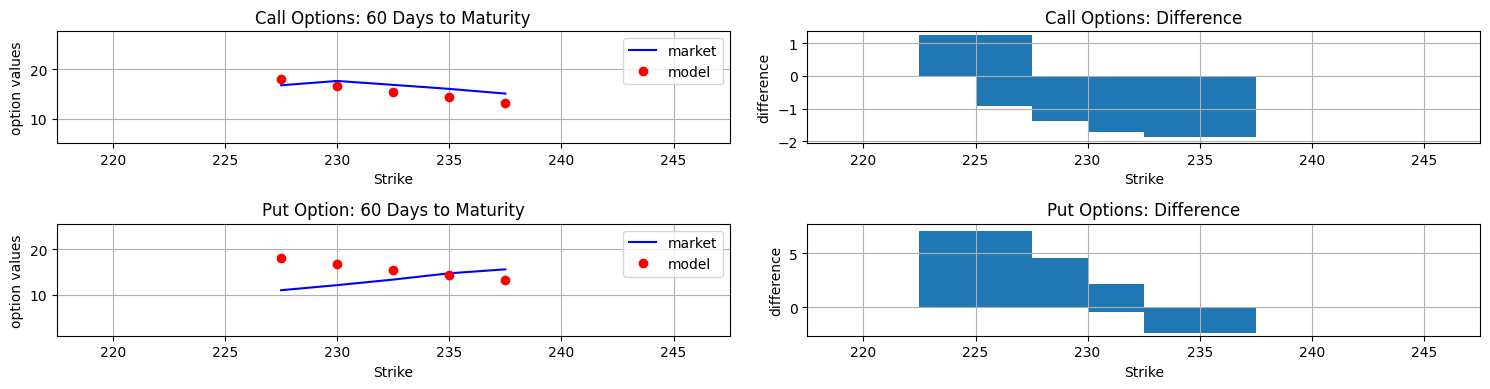

In [153]:
plot_full_calibration_results_FFT(params_full_FFT)

Pricing Put option using the caliberated values

In [ ]:
kappa_vf, theta_vf, sigma_vf, rho_f, v0_f, lamb_f, mu_f, delta_f = params_full_FFT
K = 221.255 #95% OF Current stock price
T_70 = 70/250

In [ ]:
C0 = B96_call_value_FFT(S0, K, T_70, r, kappa_vf, theta_vf, sigma_vf, rho_f, v0_f, lamb_f, mu_f, delta_f)


In [ ]:
put_option = C0 + K * np.exp(-r*T_70) + S0

print(
    "B96 Put option Fair price: $%1.4f"
    % put_option
)

put_option_final = put_option + 0.04 * put_option

print(
     "B96 Put option Final price: ${:.4}".format(put_option_final)
)

B96 Put option Fair price: $476.0664
B96 Put option Final price: $495.1


#Step 3

In [154]:
mat_list = np.array(( 7, 30, 90, 180, 360)) / 360
rate_list = (
    np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100
)

In [155]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

In [156]:
from scipy.interpolate import splev, splrep
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 12
)  # Create 12 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

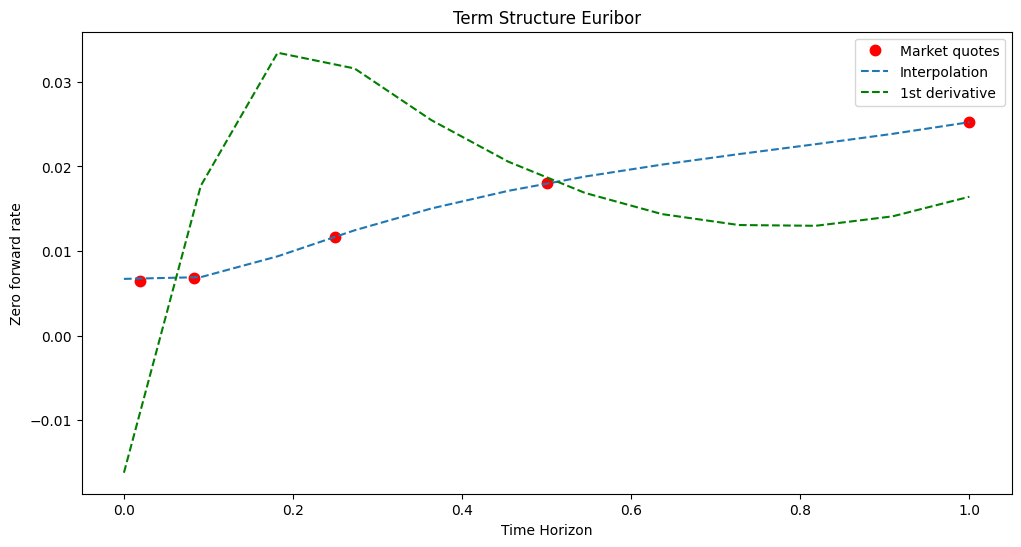

In [157]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [158]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

In [159]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

In [ ]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

In [ ]:
params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 190
         Function evaluations: 326


array([0.97491219, 0.11063425, 0.00100029])

In [ ]:
alpha_param = [0.97491219, 0.11063425, 0.00100029]
forward_rate = CIR_forward_rate(alpha_param)
print(forward_rate)

[0.00631744 0.0109844  0.01520493 0.01901557 0.02245158 0.02554679
 0.02833338 0.03084169 0.03309993 0.03513409 0.03696784 0.03862255]


In [ ]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

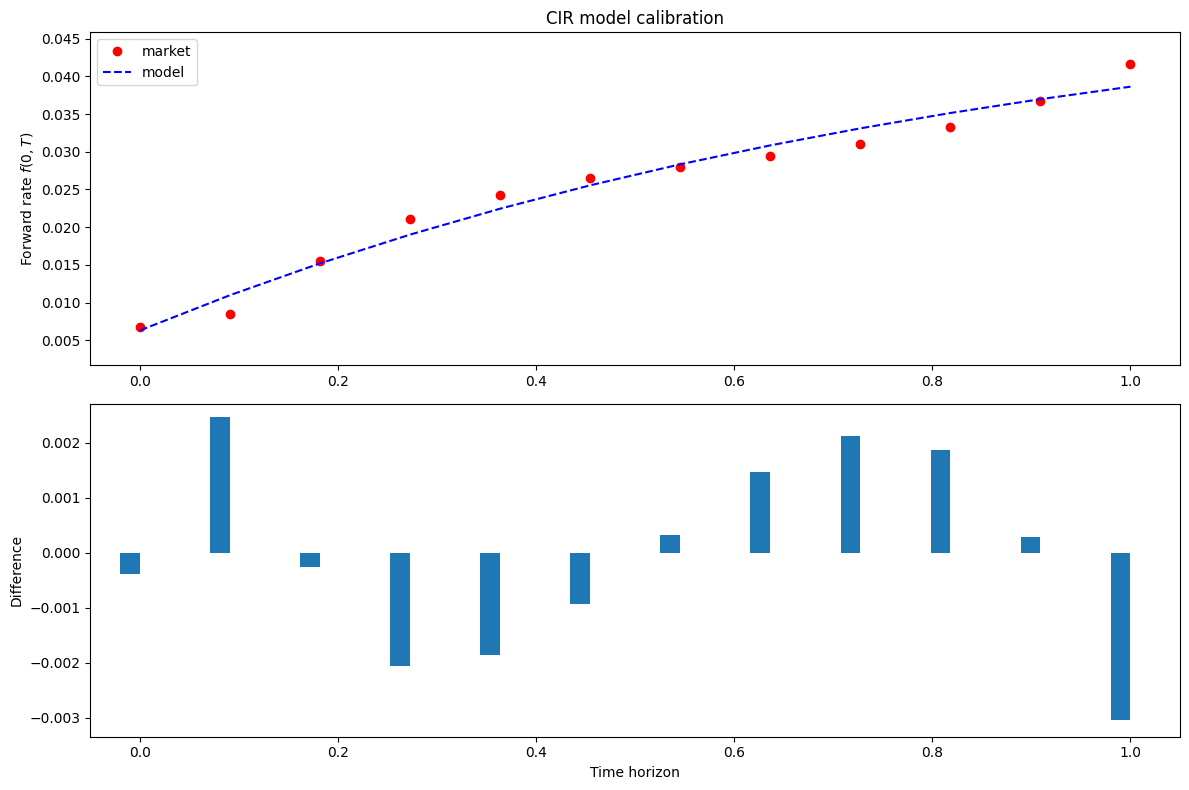

In [ ]:
plot_calibrated_frc(params)

In [161]:
def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

In [160]:
r0 = 0.648/100
k = 0.97491219
theta = 0.11063425
sigma = 0.00100029
T = 1
N = 100
M = 100000

In [ ]:
rates_cir = cir(r0, k, theta, sigma, T, N, M)

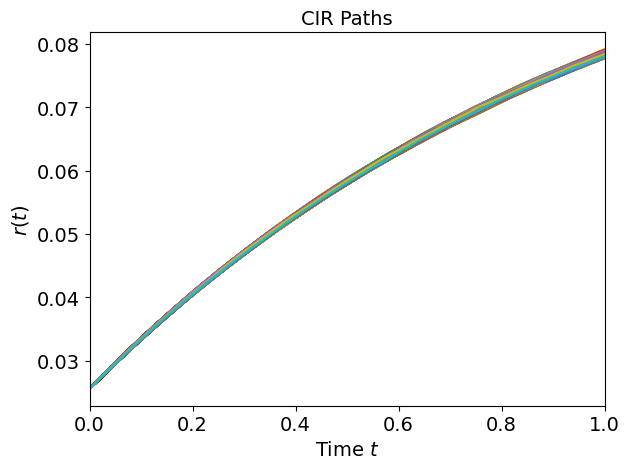

In [162]:
t = np.linspace(0, T, 100)
for j in range(M):
    plt.plot(t, rates_cir[:, j])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("CIR Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()